# Machine Learning

**Flight Delay Prediction Dataset**


Training Logistic Regression...
Accuracy: 0.9999727007179711
Precision: 0.9998683621620198
Recall: 1.0
F1 Score: 0.9999341767485946
ROC AUC: 0.9999991908997872
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    145177
           1       1.00      1.00      1.00     37978

    accuracy                           1.00    183155
   macro avg       1.00      1.00      1.00    183155
weighted avg       1.00      1.00      1.00    183155



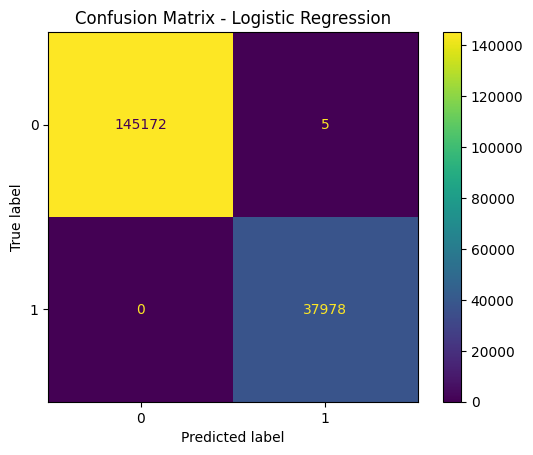


Training Random Forest...
Accuracy: 0.9959760858289427
Precision: 0.9812120428995994
Recall: 0.9997366896624361
F1 Score: 0.9903877505771262
ROC AUC: 0.9999295668380026
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    145177
           1       0.98      1.00      0.99     37978

    accuracy                           1.00    183155
   macro avg       0.99      1.00      0.99    183155
weighted avg       1.00      1.00      1.00    183155



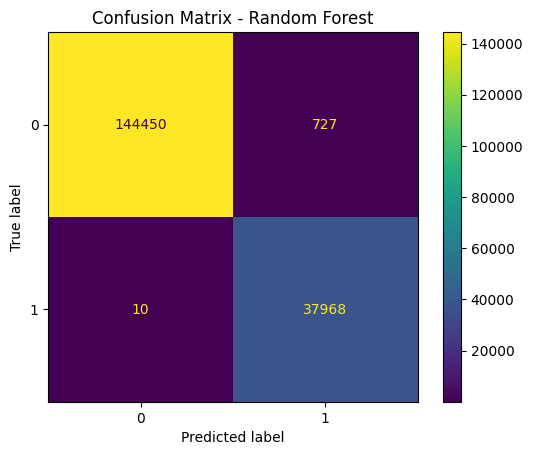


Training XGBoost...
Accuracy: 0.9992356201031913
Precision: 0.9985506482555075
Recall: 0.9977618621307073
F1 Score: 0.998156099359903
ROC AUC: 0.9999966414451491
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    145177
           1       1.00      1.00      1.00     37978

    accuracy                           1.00    183155
   macro avg       1.00      1.00      1.00    183155
weighted avg       1.00      1.00      1.00    183155



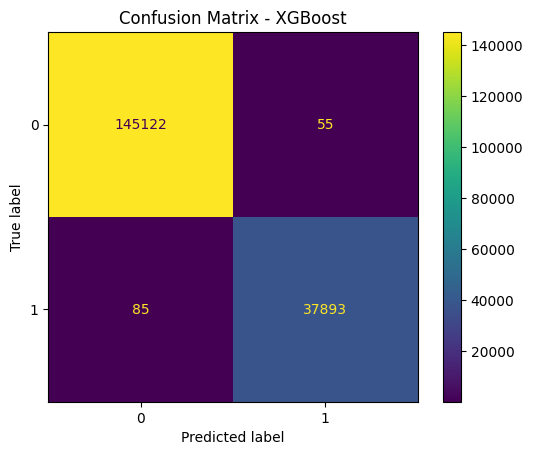

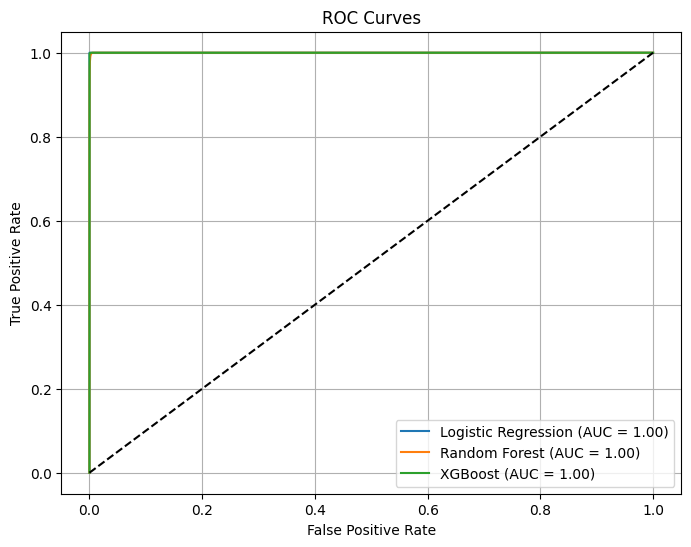

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import dask.dataframe as dd
import os

#model = RandomForestClassifier(n_jobs=-1)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve
)

# Load data with low_memory=False
df = pd.read_csv('data/flights_delay.csv', low_memory=False)
#df = dd.read_csv('flights_delay.csv')

# Convert known problematic columns to string to avoid int/str mix
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].astype(str)
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].astype(str)

# Create target variable
df['ARR_DEL15'] = df['ARRIVAL_DELAY'].apply(lambda x: 1 if pd.notna(x) and x > 15 else 0)

# Drop irrelevant or redundant columns
df.drop(columns=[
    'FLIGHT_NUMBER', 'TAIL_NUMBER', 'YEAR', 'CANCELLED', 'CANCELLATION_REASON',
    'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME'
], inplace=True)

# Feature selection
features = [
    'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'DEPARTURE_DELAY', 'DISTANCE', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
    'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]
X = df[features]
y = df['ARR_DEL15']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Clean numeric features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model pipelines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    #"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

model = RandomForestClassifier(n_jobs=-1)

results = {}

# Create the figures directory if it doesn't exist
if not os.path.exists('figures'):
    os.makedirs('figures')

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Build full pipeline
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train
    full_pipeline.fit(X_train, y_train)

    # Predict
    y_pred = full_pipeline.predict(X_test)
    y_proba = full_pipeline.predict_proba(X_test)[:, 1]

    # Evaluate
    results[name] = {
        'pipeline': full_pipeline,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'report': classification_report(y_test, y_pred),
        'proba': y_proba
    }

    print("Accuracy:", results[name]['accuracy'])
    print("Precision:", results[name]['precision'])
    print("Recall:", results[name]['recall'])
    print("F1 Score:", results[name]['f1'])
    print("ROC AUC:", results[name]['roc_auc'])
    print("Classification Report:\n", results[name]['report'])

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.savefig(f"figures/confusion_matrix_{name.replace(' ', '_')}.png")
    plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for name in models:
    fpr, tpr, _ = roc_curve(y_test, results[name]['proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('figures/flight_roc_curve.png')
plt.show()

**Heart Disease Dataset**

Data Shape: (297, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition']
Missing Values:
 age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64


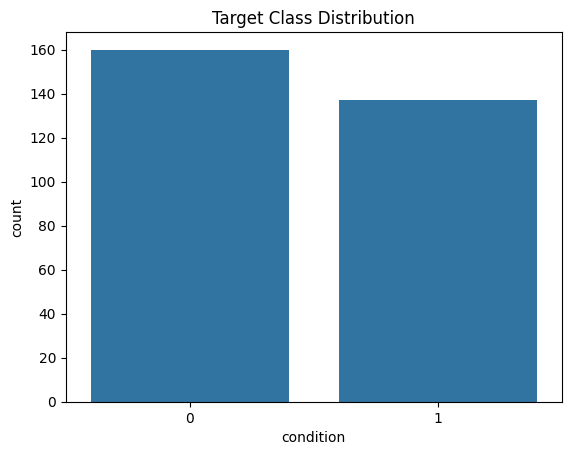

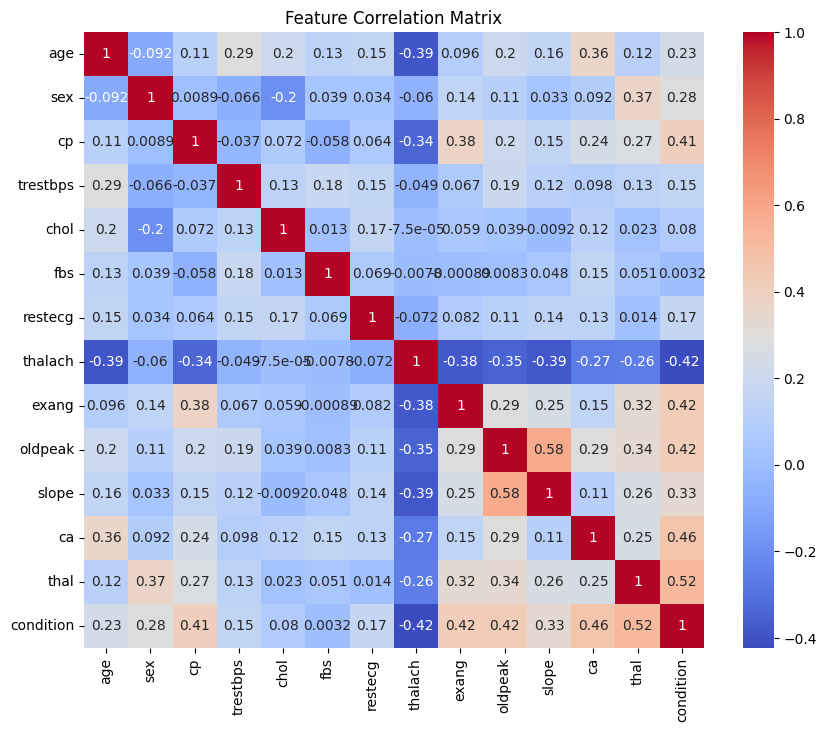

KNN Accuracy: 0.6333333333333333
KNN Macro F1: 0.6228571428571429
Confusion Matrix:
 [[24  8]
 [14 14]]
              precision    recall  f1-score   support

           0       0.63      0.75      0.69        32
           1       0.64      0.50      0.56        28

    accuracy                           0.63        60
   macro avg       0.63      0.62      0.62        60
weighted avg       0.63      0.63      0.63        60

SVM Accuracy: 0.4666666666666667
SVM Macro F1: 0.3181818181818182
Confusion Matrix:
 [[ 0 32]
 [ 0 28]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.47      1.00      0.64        28

    accuracy                           0.47        60
   macro avg       0.23      0.50      0.32        60
weighted avg       0.22      0.47      0.30        60

Best SVM Parameters: {'C': 0.1, 'gamma': 'scale'}


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Load data (Corrected the filename)
df_heart = pd.read_csv('data/heart_cleveland_upload.csv')

# EDA
print("Data Shape:", df_heart.shape)
print("Columns:", df_heart.columns.tolist())
print("Missing Values:\n", df_heart.isnull().sum())

# Target class distribution
sns.countplot(x='condition', data=df_heart)  # Changed from 'target' to 'condition'
plt.title("Target Class Distribution")
plt.show()

# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df_heart.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Preprocessing
X = df_heart.drop(columns=['condition'])  # Changed from 'target' to 'condition'
y = df_heart['condition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Train models
knn = KNeighborsClassifier()
svm = SVC(kernel='rbf', probability=True)

knn.fit(X_train_scaled, y_train)
svm.fit(X_train_scaled, y_train)

# Predict
y_pred_knn = knn.predict(X_test)
y_pred_svm = svm.predict(X_test)

# Evaluate KNN
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Macro F1:", f1_score(y_test, y_pred_knn, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

# Evaluate SVM
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Macro F1:", f1_score(y_test, y_pred_svm, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Hyperparameter Tuning for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train_scaled, y_train)

best_svm = grid.best_estimator_
print("Best SVM Parameters:", grid.best_params_)